Snake Game with Deep Q-Learning (DQN)
This notebook implements a complete reinforcement learning solution for the classic Snake game using Deep Q-Networks (DQN). The AI agent learns to play Snake through trial and error, gradually improving its performance over time.

Table of Contents

Setup and Imports
Neural Network Model
Game Environment
RL Agent
Training Visualization
Training Loop
Results and Analysis

1. Setup and Imports {#setup}
First, let's import all the necessary libraries and set up our environment.

In [1]:
# Core libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import os
from collections import deque, namedtuple
from enum import Enum

# Game and visualization
import pygame
import matplotlib.pyplot as plt
from IPython import display

# Initialize pygame
pygame.init()

# Set up matplotlib for real-time plotting
plt.ion()

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

pygame 2.6.1 (SDL 2.28.4, Python 3.12.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: False


2. Neural Network Model {#model}
Here we define our Deep Q-Network architecture and the training class.

In [2]:
# Q NETWORK ARCHITECTURE

class Linear_QNet(nn.Module):
    """
    Deep Q-Network with one hidden layer

    Args:
        input_size (int): Size of state vector (11 features)
        hidden_size (int): Number of neurons in hidden layer
        output_size (int): Number of actions (3: straight, right, left)
    """
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))  # ReLU activation for hidden layer
        x = self.linear2(x)          # Linear output layer
        return x

    def save(self, file_name='model.pth'):
        """Save model state dictionary"""
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)
        print(f"Model saved to {file_name}")

In [3]:
#Q LEARNING TRAINER

class QTrainer:
    """
    Handles the training of the Q-Network using the Bellman equation
    """
    def __init__(self, model, lr, gamma):
        self.lr = lr                                    # Learning rate
        self.gamma = gamma                              # Discount factor
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        """
        Perform one training step using Q-learning update rule:
        Q_new = reward + gamma * max(next_predicted_Q_value)
        """
        # Convert to tensors
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)

        # Handle single sample vs batch
        if len(state.shape) == 1:
            # Reshape for single sample
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        # 1. Get predicted Q values for current state
        pred = self.model(state)
        target = pred.clone()

        # 2. Apply Q-learning update rule
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                # Q_new = r + γ * max(Q(s',a'))
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            target[idx][torch.argmax(action[idx]).item()] = Q_new

        # 3. Perform gradient descent
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()
        self.optimizer.step()

3. Game Environment {#environment}
Now let's implement the Snake game environment that our agent will interact with.

In [4]:
# GAME CONSTANTS AND UTILITIES

# Game constants
BLOCK_SIZE = 20
SPEED = 40

# Colors (RGB)
WHITE = (255, 255, 255)
RED = (200, 0, 0)
BLUE1 = (0, 0, 255)
BLUE2 = (0, 100, 255)
BLACK = (0, 0, 0)

# Direction enumeration
class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

# Point structure for coordinates
Point = namedtuple('Point', 'x, y')

# Font for score display
try:
    font = pygame.font.Font('arial.ttf', 25)
except:
    font = pygame.font.SysFont('arial', 25)

print("Game constants and utilities defined!")

Game constants and utilities defined!


In [5]:
# SNAKE GAME AI ENVIRONMENT

class SnakeGameAI:
    """
    Snake game environment optimized for AI training
    """
    def __init__(self, w=640, h=480):
        self.w = w
        self.h = h
        # Initialize display
        self.display = pygame.display.set_mode((self.w, self.h))
        pygame.display.set_caption('Snake AI Training')
        self.clock = pygame.time.Clock()
        self.reset()

    def reset(self):
        """Reset game to initial state"""
        # Initialize game state
        self.direction = Direction.RIGHT

        # Initialize snake in center, moving right
        self.head = Point(self.w/2, self.h/2)
        self.snake = [self.head,
                      Point(self.head.x-BLOCK_SIZE, self.head.y),
                      Point(self.head.x-(2*BLOCK_SIZE), self.head.y)]

        self.score = 0
        self.food = None
        self._place_food()
        self.frame_iteration = 0

    def _place_food(self):
        """Place food randomly, avoiding snake body"""
        x = random.randint(0, (self.w-BLOCK_SIZE)//BLOCK_SIZE) * BLOCK_SIZE
        y = random.randint(0, (self.h-BLOCK_SIZE)//BLOCK_SIZE) * BLOCK_SIZE
        self.food = Point(x, y)

        # Ensure food doesn't spawn on snake
        if self.food in self.snake:
            self._place_food()

    def play_step(self, action):
        """
        Execute one game step with given action

        Args:
            action: [straight, right_turn, left_turn] as one-hot vector

        Returns:
            reward, game_over, score
        """
        self.frame_iteration += 1

        # 1. Handle pygame events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()

        # 2. Move snake based on action
        self._move(action)
        self.snake.insert(0, self.head)

        # 3. Check game over conditions
        reward = 0
        game_over = False

        # Game over if collision or taking too long
        if self.is_collision() or self.frame_iteration > 100*len(self.snake):
            game_over = True
            reward = -10
            return reward, game_over, self.score

        # 4. Check if food eaten
        if self.head == self.food:
            self.score += 1
            reward = 10
            self._place_food()
        else:
            self.snake.pop()  # Remove tail if no food eaten

        # 5. Update display
        self._update_ui()
        self.clock.tick(SPEED)

        return reward, game_over, self.score

    def is_collision(self, pt=None):
        """Check if point collides with boundary or snake body"""
        if pt is None:
            pt = self.head

        # Boundary collision
        if (pt.x > self.w - BLOCK_SIZE or pt.x < 0 or
            pt.y > self.h - BLOCK_SIZE or pt.y < 0):
            return True

        # Self collision
        if pt in self.snake[1:]:
            return True

        return False

    def _update_ui(self):
        """Update game display"""
        self.display.fill(BLACK)

        # Draw snake
        for pt in self.snake:
            pygame.draw.rect(self.display, BLUE1,
                           pygame.Rect(pt.x, pt.y, BLOCK_SIZE, BLOCK_SIZE))
            pygame.draw.rect(self.display, BLUE2,
                           pygame.Rect(pt.x+4, pt.y+4, 12, 12))

        # Draw food
        pygame.draw.rect(self.display, RED,
                        pygame.Rect(self.food.x, self.food.y, BLOCK_SIZE, BLOCK_SIZE))

        # Draw score
        text = font.render("Score: " + str(self.score), True, WHITE)
        self.display.blit(text, [0, 0])
        pygame.display.flip()

    def _move(self, action):
        """
        Move snake based on action

        Action mapping:
        [1,0,0] -> straight
        [0,1,0] -> right turn
        [0,0,1] -> left turn
        """
        clock_wise = [Direction.RIGHT, Direction.DOWN, Direction.LEFT, Direction.UP]
        idx = clock_wise.index(self.direction)

        if np.array_equal(action, [1, 0, 0]):
            new_dir = clock_wise[idx]  # No change
        elif np.array_equal(action, [0, 1, 0]):
            next_idx = (idx + 1) % 4
            new_dir = clock_wise[next_idx]  # Right turn
        else:  # [0, 0, 1]
            next_idx = (idx - 1) % 4
            new_dir = clock_wise[next_idx]  # Left turn

        self.direction = new_dir

        # Update head position
        x = self.head.x
        y = self.head.y
        if self.direction == Direction.RIGHT:
            x += BLOCK_SIZE
        elif self.direction == Direction.LEFT:
            x -= BLOCK_SIZE
        elif self.direction == Direction.DOWN:
            y += BLOCK_SIZE
        elif self.direction == Direction.UP:
            y -= BLOCK_SIZE

        self.head = Point(x, y)

print("Snake game environment created!")

Snake game environment created!


4. RL Agent {#agent}
Here's our DQN agent that learns to play Snake.

In [6]:
# HYPERPARAMETERS

# Training hyperparameters
MAX_MEMORY = 100_000    # Experience replay buffer size
BATCH_SIZE = 1000       # Mini-batch size for training
LR = 0.001             # Learning rate

print("Hyperparameters set:")
print(f"Max Memory: {MAX_MEMORY:,}")
print(f"Batch Size: {BATCH_SIZE:,}")
print(f"Learning Rate: {LR}")

Hyperparameters set:
Max Memory: 100,000
Batch Size: 1,000
Learning Rate: 0.001


In [7]:
# DQN AGENT IMPLEMENTATION
# Replay memory parameters
MAX_MEMORY = 100_000   # how many experiences to store
BATCH_SIZE = 1000      # how many experiences to sample for training
LR = 0.001             # learning rate

class Agent:
    """
    Deep Q-Learning Agent for Snake game
    """
    def __init__(self):
        self.n_games = 0
        self.epsilon = 0        # Exploration rate
        self.gamma = 0.9        # Discount factor
        self.memory = deque(maxlen=MAX_MEMORY)  # Experience replay buffer

        # Neural network: 11 inputs -> 256 hidden -> 3 outputs
        self.model = Linear_QNet(11, 256, 3)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

    def get_state(self, game):
        """
        Extract state features from game

        State vector (11 features):
        - Danger straight, right, left (3)
        - Current direction (4)
        - Food location relative to head (4)
        """
        head = game.snake[0]

        # Points around head
        point_l = Point(head.x - BLOCK_SIZE, head.y)
        point_r = Point(head.x + BLOCK_SIZE, head.y)
        point_u = Point(head.x, head.y - BLOCK_SIZE)
        point_d = Point(head.x, head.y + BLOCK_SIZE)

        # Current direction booleans
        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN

        state = [
            # Danger straight
            (dir_r and game.is_collision(point_r)) or
            (dir_l and game.is_collision(point_l)) or
            (dir_u and game.is_collision(point_u)) or
            (dir_d and game.is_collision(point_d)),

            # Danger right
            (dir_u and game.is_collision(point_r)) or
            (dir_d and game.is_collision(point_l)) or
            (dir_l and game.is_collision(point_u)) or
            (dir_r and game.is_collision(point_d)),

            # Danger left
            (dir_d and game.is_collision(point_r)) or
            (dir_u and game.is_collision(point_l)) or
            (dir_r and game.is_collision(point_u)) or
            (dir_l and game.is_collision(point_d)),

            # Move direction
            dir_l,
            dir_r,
            dir_u,
            dir_d,

            # Food location
            game.food.x < game.head.x,  # food left
            game.food.x > game.head.x,  # food right
            game.food.y < game.head.y,  # food up
            game.food.y > game.head.y   # food down
        ]

        return np.array(state, dtype=int)

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.memory.append((state, action, reward, next_state, done))

    def train_long_memory(self):
        """Train on batch of experiences from memory"""
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE)
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)

    def train_short_memory(self, state, action, reward, next_state, done):
        """Train on single experience immediately"""
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        """
        Choose action using epsilon-greedy policy

        Returns:
            action as one-hot vector [straight, right, left]
        """
        # Exploration rate decreases with number of games
        self.epsilon = 80 - self.n_games
        final_move = [0, 0, 0]

        # Exploration: random action
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        # Exploitation: action from Q-network
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move

print("DQN Agent implemented!")

DQN Agent implemented!


5. Training Visualization {#visualization}
Function to plot training progress in real-time.

In [8]:
def plot_training_progress(scores, mean_scores):
    """
    Plot training scores in real-time

    Args:
        scores: List of scores for each game
        mean_scores: List of mean scores up to each game
    """
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.title('Training Progress - Snake AI')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')

    # Plot individual scores and running mean
    plt.plot(scores, label='Score', alpha=0.7)
    plt.plot(mean_scores, label='Mean Score', linewidth=2)

    plt.ylim(ymin=0)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Annotate latest values
    if scores:
        plt.text(len(scores)-1, scores[-1], str(scores[-1]))
    if mean_scores:
        plt.text(len(mean_scores)-1, mean_scores[-1],
                f'{mean_scores[-1]:.1f}')

    plt.show(block=False)
    plt.pause(0.1)

print("Visualization function ready!")

Visualization function ready!


6. Training Loop {#training}
Main training function that brings everything together.

In [9]:
def train_agent():
    """
    Main training loop for the Snake AI agent
    """
    print("Starting training...")
    print("=" * 50)

    # Initialize tracking variables
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0

    # Create agent and game
    agent = Agent()
    game = SnakeGameAI()

    try:
        while True:
            # Get current state
            state_old = agent.get_state(game)

            # Get action from agent
            final_move = agent.get_action(state_old)

            # Perform action and get new state
            reward, done, score = game.play_step(final_move)
            state_new = agent.get_state(game)

            # Train short memory (immediate learning)
            agent.train_short_memory(state_old, final_move, reward, state_new, done)

            # Store experience in memory
            agent.remember(state_old, final_move, reward, state_new, done)

            if done:
                # Game over - train long memory and update tracking
                game.reset()
                agent.n_games += 1
                agent.train_long_memory()

                # Save model if new record
                if score > record:
                    record = score
                    agent.model.save()
                    print(f"🎉 New record! Game {agent.n_games}, Score: {score}")

                # Update progress tracking
                print(f"Game {agent.n_games:4d} | Score: {score:2d} | Record: {record:2d} | "
                      f"Epsilon: {agent.epsilon:2d}")

                plot_scores.append(score)
                total_score += score
                mean_score = total_score / agent.n_games
                plot_mean_scores.append(mean_score)

                # Update plot every 10 games for performance
                if agent.n_games % 10 == 0:
                    plot_training_progress(plot_scores, plot_mean_scores)

                # Stop training after reaching good performance or many games
                if agent.n_games >= 1000 or record >= 50:
                    print(f"\n🏆 Training completed!")
                    print(f"Final record: {record}")
                    print(f"Games played: {agent.n_games}")
                    break

    except KeyboardInterrupt:
        print(f"\n⏹️ Training stopped by user")
        print(f"Games played: {agent.n_games}")
        print(f"Best score: {record}")

    pygame.quit()
    return plot_scores, plot_mean_scores, record

print("Training function ready!")
print("Run train_agent() to start training!")

Training function ready!
Run train_agent() to start training!


7. Run Training {#training-run}
Execute the training loop (uncomment to run):

<Figure size 640x480 with 0 Axes>

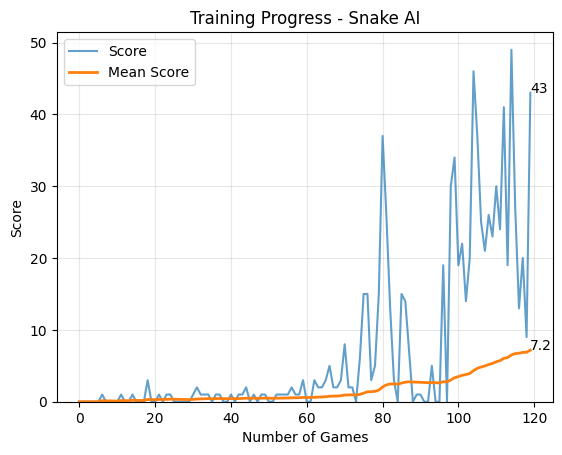

Game  121 | Score: 25 | Record: 49 | Epsilon: -40
Game  122 | Score: 26 | Record: 49 | Epsilon: -41
Game  123 | Score: 28 | Record: 49 | Epsilon: -42
Model saved to ./model/model.pth
🎉 New record! Game 124, Score: 51
Game  124 | Score: 51 | Record: 51 | Epsilon: -43

🏆 Training completed!
Final record: 51
Games played: 124


In [10]:
# Uncomment the line below to start training
scores, mean_scores, final_record = train_agent()

8. Results and Analysis {#results}
Performance Analysis

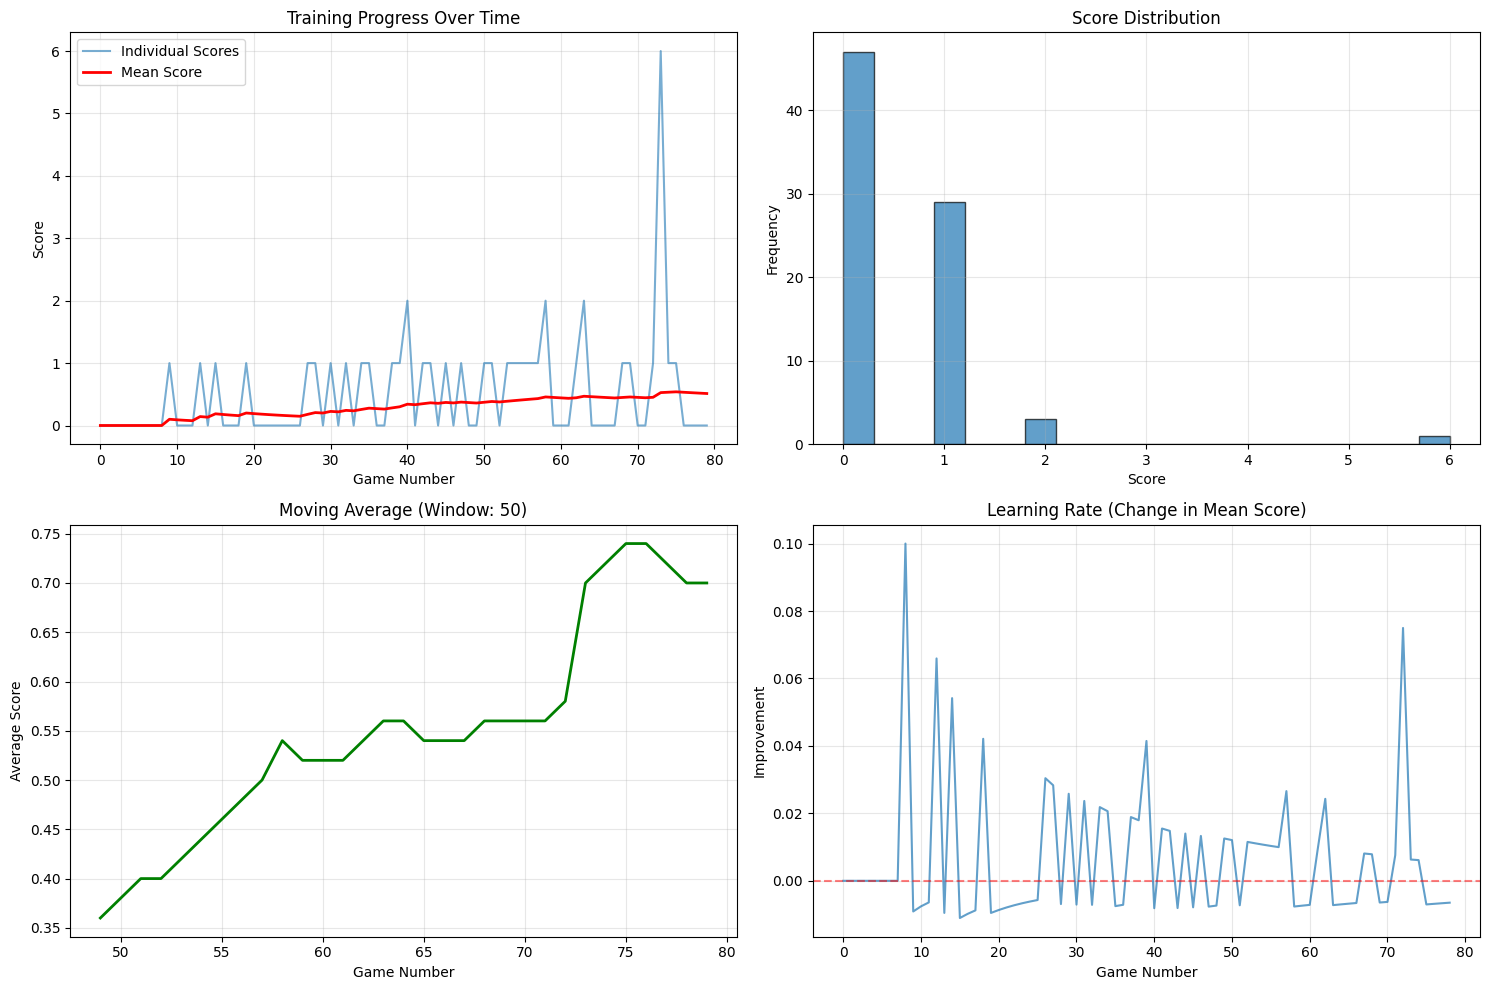

Training Statistics:
Total games played: 80
Best score achieved: 6
Average score: 0.51
Standard deviation: 0.84
Final 100 games average: 0.51


In [ ]:
def analyze_training_results(scores, mean_scores):
    """
    Analyze and visualize training results
    """
    if not scores:
        print("No training data to analyze. Run training first!")
        return

    plt.figure(figsize=(15, 10))

    # Plot 1: Training Progress
    plt.subplot(2, 2, 1)
    plt.plot(scores, alpha=0.6, label='Individual Scores')
    plt.plot(mean_scores, 'r-', linewidth=2, label='Mean Score')
    plt.title('Training Progress Over Time')
    plt.xlabel('Game Number')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Score Distribution
    plt.subplot(2, 2, 2)
    plt.hist(scores, bins=20, alpha=0.7, edgecolor='black')
    plt.title('Score Distribution')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    # Plot 3: Moving Average
    plt.subplot(2, 2, 3)
    window_size = 50
    if len(scores) >= window_size:
        moving_avg = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(scores)), moving_avg, 'g-', linewidth=2)
        plt.title(f'Moving Average (Window: {window_size})')
        plt.xlabel('Game Number')
        plt.ylabel('Average Score')
        plt.grid(True, alpha=0.3)

    # Plot 4: Learning Progress
    plt.subplot(2, 2, 4)
    improvement = np.diff(mean_scores)
    plt.plot(improvement, alpha=0.7)
    plt.title('Learning Rate (Change in Mean Score)')
    plt.xlabel('Game Number')
    plt.ylabel('Improvement')
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("Training Statistics:")
    print(f"Total games played: {len(scores)}")
    print(f"Best score achieved: {max(scores)}")
    print(f"Average score: {np.mean(scores):.2f}")
    print(f"Standard deviation: {np.std(scores):.2f}")
    print(f"Final 100 games average: {np.mean(scores[-100:]):.2f}")

# Uncomment to analyze results after training
analyze_training_results(scores, mean_scores)

Load and Test Trained Model

In [ ]:
def test_trained_model():
    """
    Load saved model and test its performance
    """
    print("Testing trained model...")

    # Create agent and load trained model
    agent = Agent()
    agent.epsilon = 0  # No exploration during testing

    try:
        agent.model.load_state_dict(torch.load('./model/model.pth'))
        print("Model loaded successfully!")
    except FileNotFoundError:
        print("No trained model found. Train the agent first!")
        return

    # Test for 10 games
    game = SnakeGameAI()
    test_scores = []

    for i in range(10):
        game.reset()
        score = 0

        while True:
            state = agent.get_state(game)
            action = agent.get_action(state)
            reward, done, score = game.play_step(action)

            if done:
                break

        test_scores.append(score)
        print(f"Test Game {i+1}: Score = {score}")

    print(f"\nTest Results:")
    print(f"Average Score: {np.mean(test_scores):.2f}")
    print(f"Best Score: {max(test_scores)}")
    print(f"Worst Score: {min(test_scores)}")

    pygame.quit()
    return test_scores

# Uncomment to test the trained model
# test_scores = test_trained_model()

: 

This notebook implements a complete Deep Q-Learning solution for the Snake game with the following key components:
Reinforcement Learning Concepts Used:

Q-Learning: Value-based RL algorithm
Deep Q-Networks (DQN): Neural network for Q-value approximation
Experience Replay: Random sampling from memory buffer
Epsilon-Greedy Policy: Balancing exploration vs exploitation
Temporal Difference Learning: Bellman equation updates

Key Features:

11-dimensional state representation
3-action discrete action space
Experience replay with 100k buffer
Epsilon decay schedule
Real-time training visualization
Model persistence and testing

Training Process:

Agent observes game state
Chooses action using epsilon-greedy policy
Receives reward and new state
Stores experience in replay buffer
Trains on random batch from buffer
Repeats until convergence

The agent typically learns to achieve scores of 20-40+ after several hundred training games, demonstrating successful reinforcement learning in a classic game environment.
To run the training, simply uncomment the training calls in the respective sections!